<a href="https://colab.research.google.com/github/vzinkovski/forecasting_trading_futures_ml_ensembles/blob/main/forecasting_trading_soybean_futures_ml_ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting and Trading CME Soybean Futures with ML Ensembles

*Last updated: 01 Feb 2024*

**Introduction**

In financial economics, the efficient market hypothesis (EMH) posits that all available information regarding a given security is reflected in its price. There exist a weak, semi-strong and strong form EMH, but all agree that it is essentially not possible to consistently outperform the market.

While the EMH has been influential in financial theory, it has also faced criticism. Some argue that there are situations where markets are not perfectly efficient, and anomalies do exist. For example, behavioural finance explores how psychological factors can lead to market inefficiencies and deviations from the EMH. Empirically, numerous hedge funds and trading houses, both systematic and discretionary, have also proven capable in outperforming the market over the long run.

**Objective**

In this project we will endeavour to exploit any such inefficiencies in the price and build an ensemble of supervised learning machine models to forecast returns of CME soybean futures. In contrast to absolute price levels, returns are well-known to be stationary and therefore lend themselves better to modeling.

Our model aims to forecast whether the closing price tomorrow will be higher than today. Naturally, we could extend this methodology and build another model to forecast whether tomorrow's price will be lower than today. However, for brevity, this project will focus on the former. The code, however, is easily extendable to the latter scenario.

Once our model has been built and tuned, we then develop a simple trading strategy. If we predict tomorrow's price to close higher, we enter a long position for a holding period of just one day. Finally, we evaluate the performance of this strategy versus an outright buy-and-hold strategy.

Note that our model can equally be applied in forecasting returns for other commodities futures contracts, stock prices, currency pairs, etc.

## Libraries

In [1]:
%%capture

# install missing libraries
!pip install watermark # record dependencies

In [2]:
%%capture

# standard libraries
import numpy as np
import pandas as pd
import scipy.stats

# machine learning libraries
import lightgbm as lgb
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, precision_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb

# visualisation libraries
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# api libraries
import yfinance as yf

# utility
import warnings

In [3]:
# pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

# other display
warnings.filterwarnings("ignore", category=Warning)

## Load data

We use the Yahoo! Finance API to download daily OHLC and volume data for CME soybean futures starting from Sep 2000 until present.

In [4]:
# define commodity futures contract
ticker = 'ZS=F' # cme soybeans
ticker_name = 'soybean'

# download ohlc price and volume data
main_df = yf.download([ticker])

[*********************100%%**********************]  1 of 1 completed


## Preprocess data

We remove uninformative columns and check for missing values and outliers, as well as inspect key summary statistics such as mean, min and max values to ensure that our data is orderly.

In [5]:
# drop uninformative columns
main_df.drop('Close', axis=1, inplace=True)

# rename columns for convenience
main_df.rename(columns={'Adj Close': 'Close'}, inplace=True)

In [6]:
# check missing values
main_df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [7]:
# check outliers
main_df.describe()

,Open,High,Low,Close,Volume
count,5881.00,5881.00,5881.00,5881.00,5881.00
mean,1002.41,1012.02,993.93,1002.77,49936.72
std,337.55,342.63,332.67,337.54,55153.07
min,418.00,418.50,418.00,418.50,0.00
25%,750.50,757.50,744.50,751.00,755.00
50%,971.25,981.00,964.50,971.50,23359.00
75%,1309.00,1321.75,1295.50,1308.25,95500.00
max,1778.50,1794.75,1760.50,1771.00,352462.00


In [8]:
# check duplicate dates
main_df.duplicated().sum()

0

### Define train validation test date ranges

We have approximately 24 years worth of data. Commonly 20-25% is set aside for validation and testing. As such, we use 18 year's worth of data to train our model, 3 years to validate and tune our model, and the remaining 3 years as the test set to perform one final evaluation of the model across key performance metrics.

In [9]:
# specify training date range
end_train_date = '2017-12-31'
end_valid_date = '2020-12-31'

### Define target variable

In order to define our target variable, we first compute daily percentage change in closing prices. For all values above zero percent, we label these as our positive class 1. All other values are our negative class 0. This is in line with convention within the machine learning community and the 1 and 0 carry no particular meaning and we could have alternatively labeled these as 1 and -1. Note that if we were trying to forecast negative returns, all we would need to do is simply reverse the class labels where all down days are labeled as the postive class 1.

Next, to convert our time series problem into a supervised learning problem, we define the CME soybeans returns at timestep $t_{+1}$ as our target variable $y$. This requires backshifting our categorical class returns column which also ensures we avoid any lookahead.

In [10]:
# define spread categorical classes
main_df['return_1t'] = main_df['Close'].pct_change() * 100
main_df['return_class'] = main_df['return_1t'].apply(lambda x: 1 if x > 0 else 0)

# create target variable y
main_df['y'] = main_df['return_class'].shift(-1)

# drop missing rows
main_df.dropna(inplace=True)

### Check class imbalance

Given the stationary nature of price returns, we would expect these to have a mean centred around zero with no time variant change in variance. A visual inspection of the below plot confirms this is the case.

Additionally, this also implies that our positive and negative classes will be balanced. Different literature will give a different definition of what a balanced class distribution should be like. Our data is distributed roughly 51.5% positive vs. 48.5% negative. Even by the strictest definitions this is considered balanced as it provides our machine learning models with a representative number of obervations in each class so that they are able to learn how to discriminate effectively.

Note, we perform these checks strictly over the training and validation portion of our data in order to avoid lookahead. The test set needs to remain as strictly unseen data until final model evaluation.

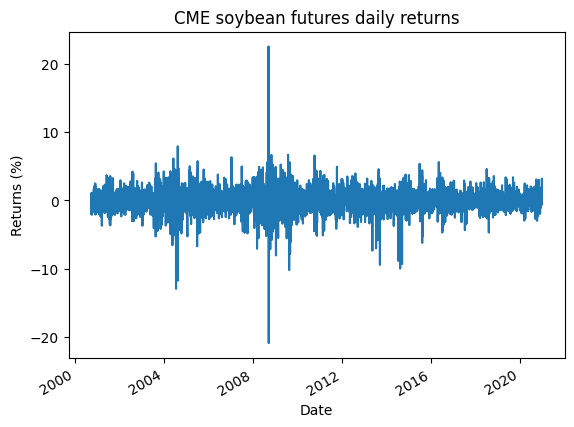

In [11]:
# display stationarity of returns
main_df['return_1t'][:end_valid_date].plot()
plt.title('CME soybean futures daily returns')
plt.ylabel('Returns (%)')
plt.show()

# clean up column
main_df.drop('return_1t', axis=1, inplace=True)

In [12]:
# check class imbalance
print(f"""
    Positive class: {main_df['y'][:end_valid_date].value_counts(normalize=True)[1]:.4f}
    Negative class: {main_df['y'][:end_valid_date].value_counts(normalize=True)[0]:.4f}
""")


    Positive class: 0.5150
    Negative class: 0.4850



## Feature engineering

continue here

### Return features

In [13]:
def return_features(df, columns, periods):

    # compute percentage changes between periods
    for period in range(1, periods+1):
        new_cols = [f'{col}_return_{period}t' for col in columns]
        df[new_cols] = df[columns].pct_change(periods=period)

    return df

### Rolling features

In [14]:
def rolling_features(df, columns, windows):

    # define column names
    mean_cols = [f'{col}_mean' for col in columns]
    std_cols = [f'{col}_std' for col in columns]
    min_cols = [f'{col}_min' for col in columns]
    max_cols = [f'{col}_max' for col in columns]

    # add rolling mean, std, min and max features
    for window in windows:

        mean_colnames = [f'{col}_{window}t' for col in mean_cols]
        df[mean_colnames] = df[columns].rolling(window=window).mean()

        std_colnames = [f'{col}_{window}t' for col in std_cols]
        df[std_colnames] = df[columns].rolling(window=window).std()

        min_colnames = [f'{col}_{window}t' for col in min_cols]
        df[min_colnames] = df[columns].rolling(window=window).min()

        max_colnames = [f'{col}_{window}t' for col in max_cols]
        df[max_colnames] = df[columns].rolling(window=window).max()

    return df

### Lagged features

In [15]:
def lagged_features(df, columns, lags):

    # create columns containing lagged values
    for lag in range(1, lags+1):
        new_cols = [f'{col}_t-{lag}' for col in columns]
        df[new_cols] = df[columns].shift(periods=lag)

    return df

### Custom features

In [16]:
def custom_features(df):

    # add max-min range features
    df['Close_return_5t_min_max_range'] = df['Close_return_1t_max_5t'] - df['Close_return_1t_min_5t']
    df['Close_return_10t_min_max_range'] = df['Close_return_1t_max_10t'] - df['Close_return_1t_min_10t']
    df['Close_return_20t_min_max_range'] = df['Close_return_1t_max_20t'] - df['Close_return_1t_min_20t']
    df['Close_return_30t_min_max_range'] = df['Close_return_1t_max_30t'] - df['Close_return_1t_min_30t']
    df['Close_return_40t_min_max_range'] = df['Close_return_1t_max_40t'] - df['Close_return_1t_min_40t']

    # add moving average crossover features
    df['Close_return_long_med_macd'] = df['Close_return_1t_mean_20t'] - df['Close_return_1t_mean_10t']
    df['Close_return_long_short_macd'] = df['Close_return_1t_mean_20t'] - df['Close_return_1t_mean_5t']
    df['Close_return_med_short_macd'] = df['Close_return_1t_mean_10t'] - df['Close_return_1t_mean_5t']

    # add oscillator features
    df['Close_return_5t_rsi'] = df['Close_return_1t'] / df['Close_return_1t_max_5t']
    df['Close_return_10t_rsi'] = df['Close_return_1t'] / df['Close_return_1t_max_10t']
    df['Close_return_20t_rsi'] = df['Close_return_1t'] / df['Close_return_1t_max_20t']
    df['Close_return_30t_rsi'] = df['Close_return_1t'] / df['Close_return_1t_max_30t']
    df['Close_return_40t_rsi'] = df['Close_return_1t'] / df['Close_return_1t_max_40t']

    # add z-score features
    df['Close_return_5t_zscore'] = (df['Close_return_1t'] - df['Close_return_1t_mean_5t']) / df['Close_return_1t_std_5t']
    df['Close_return_10t_zscore'] = (df['Close_return_1t'] - df['Close_return_1t_mean_10t']) / df['Close_return_1t_std_10t']
    df['Close_return_20t_zscore'] = (df['Close_return_1t'] - df['Close_return_1t_mean_20t']) / df['Close_return_1t_std_20t']
    df['Close_return_30t_zscore'] = (df['Close_return_1t'] - df['Close_return_1t_mean_30t']) / df['Close_return_1t_std_30t']
    df['Close_return_40t_zscore'] = (df['Close_return_1t'] - df['Close_return_1t_mean_40t']) / df['Close_return_1t_std_40t']

    return df

## Augment dataset

In [17]:
# number of periods and list of features for which to calculate returns
return_periods_far = 10
return_cols_far = ['Close']
return_periods_near = 5
return_cols_near = ['Open', 'High', 'Low', 'Volume']

# window horizon and list of features for which to calculate rolling statistics
rolling_windows = [5, 10, 20, 30, 40]
rolling_cols = ['Close_return_1t']

# number of lags and list of features on which to perform lagged operation
lagged_periods = 10
lagged_cols = ['Close_return_1t', 'return_class']

In [18]:
def feature_engineering(df):

    # feature engineering steps to perform sequentially
    df = return_features(df, return_cols_far, return_periods_far)
    df = return_features(df, return_cols_near, return_periods_near)
    df = rolling_features(df, rolling_cols, rolling_windows)
    df = lagged_features(df, lagged_cols, lagged_periods)
    df = custom_features(df)

    return df

In [19]:
# run main df through our custom feature engineering pipeline
main_df = feature_engineering(main_df)

# display dataframe size
print(f'DataFrame rows by columns: {main_df.shape}')

DataFrame rows by columns: (5879, 95)


### Handle uninformative features

In [20]:
# drop uninformative absolute value features
prices = main_df['Close'] # keep variable for later plotting
main_df.drop((return_cols_near + ['Close']), axis=1, inplace=True)

### Handle missing values

In [21]:
# handle missing values
main_df.replace([np.inf, -np.inf], np.nan, inplace=True)
main_df.ffill(inplace=True)
main_df.dropna(inplace=True)

## Train validation test split

In [22]:
# specify date for end of training data
train_df = main_df[:end_train_date]
valid_df = main_df[end_train_date:end_valid_date]
train_valid_df = main_df[:end_valid_date]
test_df = main_df[end_valid_date:]

# split training data into X and y
X_train = train_df.drop('y', axis=1)
y_train = train_df['y']

# split validation data into X and y
X_valid = valid_df.drop('y', axis=1)
y_valid = valid_df['y']

# split training+validation data into X and y
X_train_valid = train_valid_df.drop('y', axis=1)
y_train_valid = train_valid_df['y']

# split test data into X and y
X_test = test_df.drop('y', axis=1)
y_test = test_df['y']

## Set up pipeline

In [23]:
# preprocessing for numerical variables
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='median', add_indicator=True),
    StandardScaler(),
)

# preprocessing for categorical variables
categorical_transformer = make_pipeline(
    OneHotEncoder(drop='first', handle_unknown='ignore'),
)

# combine above two preprocessing steps into one pipeline step
preprocessor = make_column_transformer(
    (numerical_transformer, make_column_selector(dtype_exclude='category')),
    (categorical_transformer, make_column_selector(dtype_include='category')),
)

## Instantiate models

- discuss different model families make different errors
- width leaf wise growth vs depth wise growth
- LR is linear parametric
- KNN is nonlinear nonparametric
- remaining two tree based

### Logistic regression

In [24]:
# instantiate pipeline with logistic regression
logreg_clf = make_pipeline(
    preprocessor,
    LogisticRegression(
        random_state=42,
        n_jobs=-1,
    ),
)

# hyperparameter search space for logistic regression model
logreg_clf_params = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': scipy.stats.reciprocal(0.01, 100),
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__solver': ['liblinear', 'saga']
}

### KNN classifier

- K-Nearest Neighbors (KNN) is a non-parametric and lazy learning algorithm
- It doesn't assume a specific form for the decision boundary

In [25]:
# instantiate pipeline with knn classifier
knn_clf = make_pipeline(
    preprocessor,
    KNeighborsClassifier(n_jobs=-1),
)

# hyperparameter search space for knn classifier model
knn_clf_params = {
    'kneighborsclassifier__n_neighbors': scipy.stats.randint(5, 51),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1.0, 1.5, 2.0],
}

### XGBoost classifier

In [26]:
# instantiate xgboost classifier
xgb_clf = make_pipeline(
    preprocessor,
    xgb.XGBClassifier(
        n_estimators=100,
        random_state=42,
        objective='binary:logistic',
        importance_type='gain',
        verbosity=0,
        n_jobs=-1,
    )
)

# hyperparameter search space for xgboost classifier model
xgb_clf_params = {
    'xgbclassifier__max_depth': scipy.stats.randint(2, 11),
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'xgbclassifier__reg_alpha': [0., 0.1, 0.25, 0.5, 1.0, 1.5],
    'xgbclassifier__reg_lambda': [0., 0.25, 0.5, 1.0, 1.5, 2.0],
}

### LightGBM classifier

In [27]:
# instantiate lightgbm classifier
lgb_clf = make_pipeline(
    preprocessor,
    lgb.LGBMClassifier(
        n_estimators=100,
        random_state=42,
        objective='binary',
        importance_type='gain',
        verbosity=-1,
        n_jobs=-1,
    )
)

# hyperparameter search space for lightgbm classifier model
lgb_clf_params = {
    'lgbmclassifier__num_leaves': [16, 32, 64],
    'lgbmclassifier__learning_rate': [0.01, 0.1, 0.15],
    'lgbmclassifier__min_child_samples': scipy.stats.randint(10, 31),
    'lgbmclassifier__reg_alpha': [0., 0.1, 0.25, 0.5, 1.0, 1.5],
    'lgbmclassifier__reg_lambda': [0., 0.25, 0.5, 1.0, 1.5, 2.0],
}

# Training

## Hyperparameter tuning

In [28]:
# time series cross validation
tscv = TimeSeriesSplit(n_splits=4, test_size=252) # four test folds of approx one year each

In [29]:
def tune_hyperparams(estimator, param_dist, name, display=True):

    # perform a randomised grid search with 30 iterations
    rscv = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=30,
        scoring='precision',
        cv=tscv,
        verbose=0,
        random_state=42,
    )

    # fit randomised grid search cv object to training data
    rscv.fit(X_train, y_train)

    if display:

        # display best hyperparameter combo
        print(f'Best hyperparameters for {name}')
        print('- - -')
        for param, value in rscv.best_params_.items():
            print(f'{param}: {value}')

        # display performance metrics
        print(f"""
        Cross-validated precision score
        - - -
        Mean: \t\t{rscv.cv_results_['mean_test_score'][rscv.best_index_]:.3f}
        Std dev: \t{rscv.cv_results_['std_test_score'][rscv.best_index_]:.3f}
        """)

    return rscv.best_estimator_

### Individual model evaluation

In [30]:
%%time
logreg_clf_tuned = tune_hyperparams(logreg_clf, logreg_clf_params, 'Logistic Regression Classifier')

Best hyperparameters for Logistic Regression Classifier
- - -
logisticregression__C: 0.0838639478040256
logisticregression__class_weight: balanced
logisticregression__penalty: l1
logisticregression__solver: saga

        Cross-validated precision score
        - - -
        Mean: 		0.509
        Std dev: 	0.046
        
CPU times: user 3min 48s, sys: 11.7 s, total: 4min
Wall time: 4min 32s


In [31]:
%%time
knn_clf_tuned = tune_hyperparams(knn_clf, knn_clf_params, 'KNN Classifier')

Best hyperparameters for KNN Classifier
- - -
kneighborsclassifier__n_neighbors: 7
kneighborsclassifier__p: 1.0
kneighborsclassifier__weights: uniform

        Cross-validated precision score
        - - -
        Mean: 		0.508
        Std dev: 	0.028
        
CPU times: user 3min 34s, sys: 1.25 s, total: 3min 35s
Wall time: 2min 50s


In [32]:
%%time
xgb_clf_tuned = tune_hyperparams(xgb_clf, xgb_clf_params, 'XGBoost Classifier')

Best hyperparameters for XGBoost Classifier
- - -
xgbclassifier__learning_rate: 0.1
xgbclassifier__max_depth: 6
xgbclassifier__reg_alpha: 0.1
xgbclassifier__reg_lambda: 1.0

        Cross-validated precision score
        - - -
        Mean: 		0.512
        Std dev: 	0.034
        
CPU times: user 12min 35s, sys: 6.08 s, total: 12min 41s
Wall time: 7min 50s


In [33]:
%%time
lgb_clf_tuned = tune_hyperparams(lgb_clf, lgb_clf_params, 'LightGBM Classifier')

Best hyperparameters for LightGBM Classifier
- - -
lgbmclassifier__learning_rate: 0.1
lgbmclassifier__min_child_samples: 13
lgbmclassifier__num_leaves: 32
lgbmclassifier__reg_alpha: 1.5
lgbmclassifier__reg_lambda: 1.0

        Cross-validated precision score
        - - -
        Mean: 		0.512
        Std dev: 	0.036
        
CPU times: user 6min 9s, sys: 1.67 s, total: 6min 10s
Wall time: 3min 30s


## Ensembling models

Stacking refers to a method to blend estimators. In this strategy, some estimators are individually fitted on some training data while a final estimator is trained using the stacked predictions of these base estimators.

Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

hardvoting no longer really used as superseded by more advanced methods

talk about predict_proba and meta voting

In [34]:
# collect classifier models into a list
estimators = [
    ("logreg_clf", logreg_clf_tuned),
    ("knn_clf", knn_clf_tuned),
    ("xgb_clf", xgb_clf_tuned),
    ("lgb_clf", lgb_clf_tuned),
]

In [35]:
# instantiate voting classifier ensemble model
voting_clf  = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=-1,
)

### Voting classifier evaluation

- As a side-note, the F1 score is inherently skewed because it does not account for true negatives.
- balanced accuracy because equal emphasis on true positives and true negatives, mitigates any remaining class imbalance through weighting, it is the average of the recall for each of the binary classes
- BA formula is 1/2 * (tp/tp+fp + tn/tn+fn)
- balanced accuracy of 0.5 is random guessing
- F1 score doesn’t care about how many true negatives are being classified. When working on an imbalanced dataset that demands attention to the negatives, Balanced Accuracy does better than F1.
- In cases where positives are as important as negatives, balanced accuracy is a better metric for this than F1. F1 is a great scoring metric for imbalanced data when more attention is needed on the positives.
- You should use it when you care equally about positive and negative classes. It naturally extends the imbalanced data discussion from the last section. If we care about true negatives as much as we care about true positives then it totally makes sense to use ROC AUC.

In [36]:
%%time

# compute mean cross-validated precision score
scores = cross_val_score(
    estimator=voting_clf,
    X=X_train,
    y=y_train,
    scoring='precision',
    cv=tscv,
    n_jobs=-1,
)

# display mean and std of voting clf
print(f"""
    Cross-validated precision score
    of voting classifier ensemble
    - - -
    Mean: \t{scores.mean():.3f}
    Std dev: \t{scores.std():.3f}
""")


    Cross-validated precision score
    of voting classifier ensemble
    - - -
    Mean: 	0.516
    Std dev: 	0.028

CPU times: user 343 ms, sys: 141 ms, total: 484 ms
Wall time: 27.4 s


# Validation

In [37]:
%%capture

# fit voting classifier on training set
voting_clf.fit(X_train, y_train)

In [38]:
def adjust_threshold(X, y, train_valid_test, threshold=0.5):

    # use voting classifier to predict
    y_pred = voting_clf.predict_proba(X)[:, 1]
    y_pred[y_pred >= threshold] = 1
    y_pred[y_pred < threshold] = 0

    # show metrics
    print(f"""
        VOTING CLASSIFIER ENSEMBLE
        Performance metrics on {train_valid_test} set
        - - -
        Classification threshold: \t{threshold}
        Precision score: \t\t{precision_score(y, y_pred):.3f}
        # of trading signals: \t\t{int(sum(y_pred))}
        # of total trading days: \t{len(y)}
    """)

In [39]:
# performance metrics on validation set with default threshold
adjust_threshold(X_valid, y_valid, 'validation')


        VOTING CLASSIFIER ENSEMBLE
        Performance metrics on validation set
        - - -
        Classification threshold: 	0.5
        Precision score: 		0.534
        # of trading signals: 		436
        # of total trading days: 	756
    


## Precision recall curve

- Explain non monotonic nature of precision (and recall?) curve

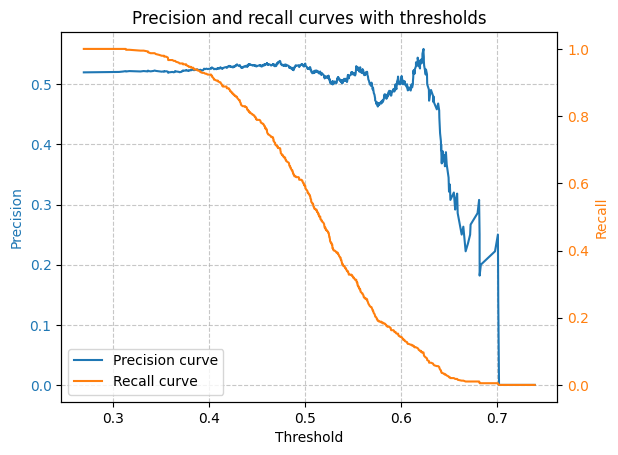

In [40]:
# predict probabilities for the validation set
y_pred = voting_clf.predict_proba(X_valid)[:, 1]

# calculate precision-recall pairs and thresholds
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred)

# plot precision against thresholds
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Precision', color=color)
ax1.plot(thresholds, precision[:-1], label='Precision curve', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# create a secondary y-axis for recall
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Recall', color=color)
ax2.plot(thresholds, recall[:-1], label='Recall curve', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# add gridlines
ax1.grid(True, linestyle='--', alpha=0.7)

# combine legends for both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower left')

# show plot
plt.title('Precision and recall curves with thresholds')
plt.show()

## Adjust classification threshold

In [41]:
# performance metrics on validation set with adjusted threshold
new_threshold = 0.62
adjust_threshold(X_valid, y_valid, 'validation', new_threshold)


        VOTING CLASSIFIER ENSEMBLE
        Performance metrics on validation set
        - - -
        Classification threshold: 	0.62
        Precision score: 		0.541
        # of trading signals: 		74
        # of total trading days: 	756
    


# Testing

In [42]:
%%capture

# fit voting classifier on training set
voting_clf.fit(X_train_valid, y_train_valid)

## Dummy classifier

In [43]:
# instantiate and fit dummy classifier on training+validation set
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(X_train_valid, y_train_valid)

# use dummy classifier to predict on test set
y_pred = dummy_clf.predict(X_test)

# show metrics
print(f"""
        DUMMY CLASSIFIER
        Performance metrics on test set
        - - -
        Classification threshold: \t0.5
        Precision score: \t\t{precision_score(y_test, y_pred):.3f}
        # of trading signals: \t\t{int(sum(y_pred))}
        # of total trading days: \t{len(y_test)}
    """)


        DUMMY CLASSIFIER
        Performance metrics on test set
        - - -
        Classification threshold: 	0.5
        Precision score: 		0.538
        # of trading signals: 		775
        # of total trading days: 	775
    


## Voting classifier

In [44]:
# use voting classifier to predict on test set
y_pred = voting_clf.predict_proba(X_test)[:, 1]
y_pred[y_pred >= new_threshold] = 1
y_pred[y_pred < new_threshold] = 0

In [45]:
adjust_threshold(X_test, y_test, 'test', new_threshold)


        VOTING CLASSIFIER ENSEMBLE
        Performance metrics on test set
        - - -
        Classification threshold: 	0.62
        Precision score: 		0.550
        # of trading signals: 		80
        # of total trading days: 	775
    


## Confusion matrix

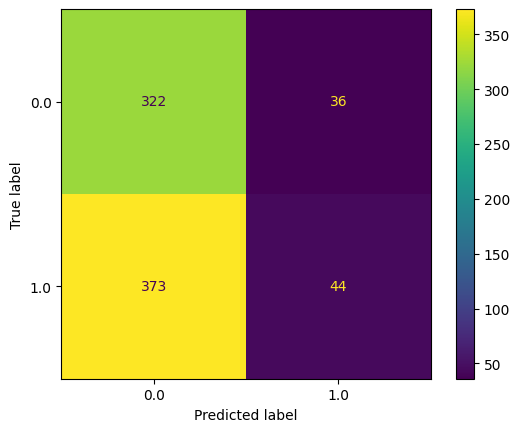

In [46]:
# display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Building a trading strategy

## Long only strategy

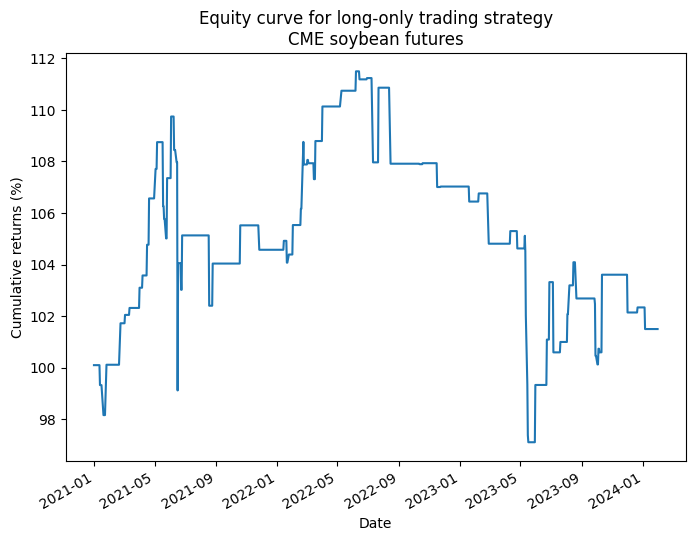

In [47]:
# calculate long only pnl
X_test['pnl_long'] = X_test['Close_return_1t'].shift(-1) * y_pred
X_test['pnl_long'] = (1 + X_test['pnl_long']).cumprod() * 100

# plot equity curve
plt.figure(figsize=(8, 6))
plt.title(f'Equity curve for long-only trading strategy\nCME {ticker_name} futures')
plt.ylabel('Cumulative returns (%)')
X_test['pnl_long'].plot()
plt.show()

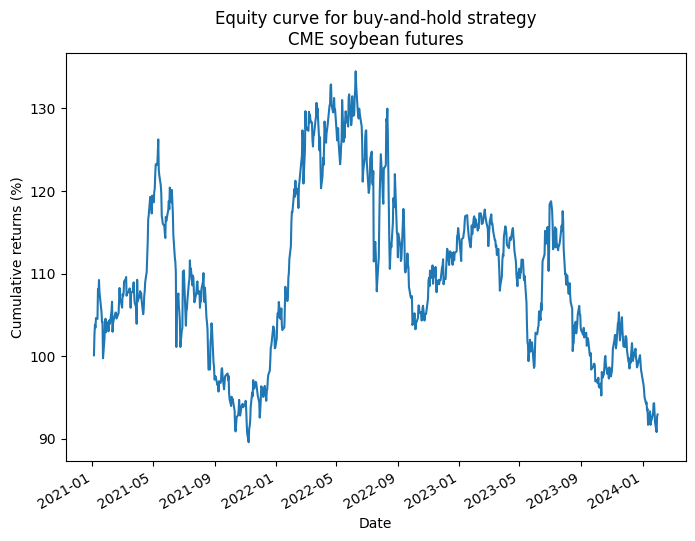

In [48]:
# set up buy and hold dataframe
prices = pd.DataFrame(prices[end_valid_date:])
prices['returns'] = prices['Close'].pct_change()
prices['equity'] = (1 + prices['returns']).cumprod() * 100

# plot equity curve
plt.figure(figsize=(8, 6))
plt.title(f'Equity curve for buy-and-hold strategy\nCME {ticker_name} futures')
plt.ylabel('Cumulative returns (%)')
prices['equity'].plot();
plt.show()

# Results

- text here
- and here

# Next steps

- build trees with more than 100 estimators
- do bayesian hyperparam opt rather than randomgrid
- if incorporating into trading strategy need to use predict proba to leverage inherent uncertainty around each prediction

# END

In [49]:
# dependencies
%load_ext watermark
%watermark --python --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

xgboost   : 2.0.3
matplotlib: 3.7.1
yfinance  : 0.2.36
numpy     : 1.23.5
pandas    : 1.5.3
lightgbm  : 4.1.0
scipy     : 1.11.4



**Author: Vladimir Zinkovski**

Send an email: *vladimir.zinkovski@gmail.com*

Or connect with me on: [LinkedIn](https://www.linkedin.com/in/vladimir-zinkovski/)